In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import sklearn.preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
FILE = 'results/cudnn/conv.csv'

In [2]:
def load_csv(file):
    df = pd.read_csv(file)
    return df

In [3]:
def one_hot_encode(df):
    precision = pd.get_dummies(df.precision)
    fwd_algo = pd.get_dummies(df.fwd_algo)
    sm_cap = pd.get_dummies(df.sm_cap)
    cuda_version = pd.get_dummies(df.cuda_version)
    df.drop(columns=['precision', 'fwd_algo', 'sm_cap', 'cuda_version'], inplace=True)
    df = pd.concat([df, precision, fwd_algo, sm_cap, cuda_version], axis=1)

    print(f'New encoded columns: {precision.columns, fwd_algo.columns, sm_cap.columns, cuda_version.columns}')
    return df

In [4]:
def normalize(X, y):
    ss = StandardScaler()
    X = pd.DataFrame(ss.fit_transform(X))
    y = pd.Series(ss.fit_transform(np.array(y).reshape(-1,1))[:,0])
    return X, y


In [5]:
df = load_csv(FILE)
df = one_hot_encode(df)
print(df.info())
print(df.describe())

New encoded columns: (Index(['float', 'half', 'int8'], dtype='object'), Index(['FFT', 'FFT_TILING', 'GEMM', 'IMPLICIT_GEMM', 'IMPLICIT_PRECOMP_GEMM',
       'WINOGRAD', 'WINOGRAD_NONFUSED'],
      dtype='object'), Index(['"7.0"', '"7.5"'], dtype='object'), Index(['"10.1"', '"11.3"'], dtype='object'))
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44152 entries, 0 to 44151
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   w                                44152 non-null  int64
 1   h                                44152 non-null  int64
 2   c                                44152 non-null  int64
 3   n                                44152 non-null  int64
 4   k                                44152 non-null  int64
 5   f_w                              44152 non-null  int64
 6   f_h                              44152 non-null  int64
 7   pad_w                            44152 non-n

array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'n'}>,
        <AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'f_w'}>],
       [<AxesSubplot:title={'center':'f_h'}>,
        <AxesSubplot:title={'center':'pad_w'}>,
        <AxesSubplot:title={'center':'pad_h'}>,
        <AxesSubplot:title={'center':'stride_w'}>,
        <AxesSubplot:title={'center':'stride_h'}>,
        <AxesSubplot:title={'center':'fwd_time(usec)'}>],
       [<AxesSubplot:title={'center':'pad_kernels'}>,
        <AxesSubplot:title={'center':'global_mem_bytes'}>,
        <AxesSubplot:title={'center':'cuda_cores'}>,
        <AxesSubplot:title={'center':'max_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_clock_rate_Mhz'}>,
        <AxesSubplot:title={'center':'mem_bus_width'}>],
       [<AxesSubplot:title={'center':'l2_cache_size'}>,
        <AxesSubplot:title={'c

<Figure size 432x288 with 0 Axes>

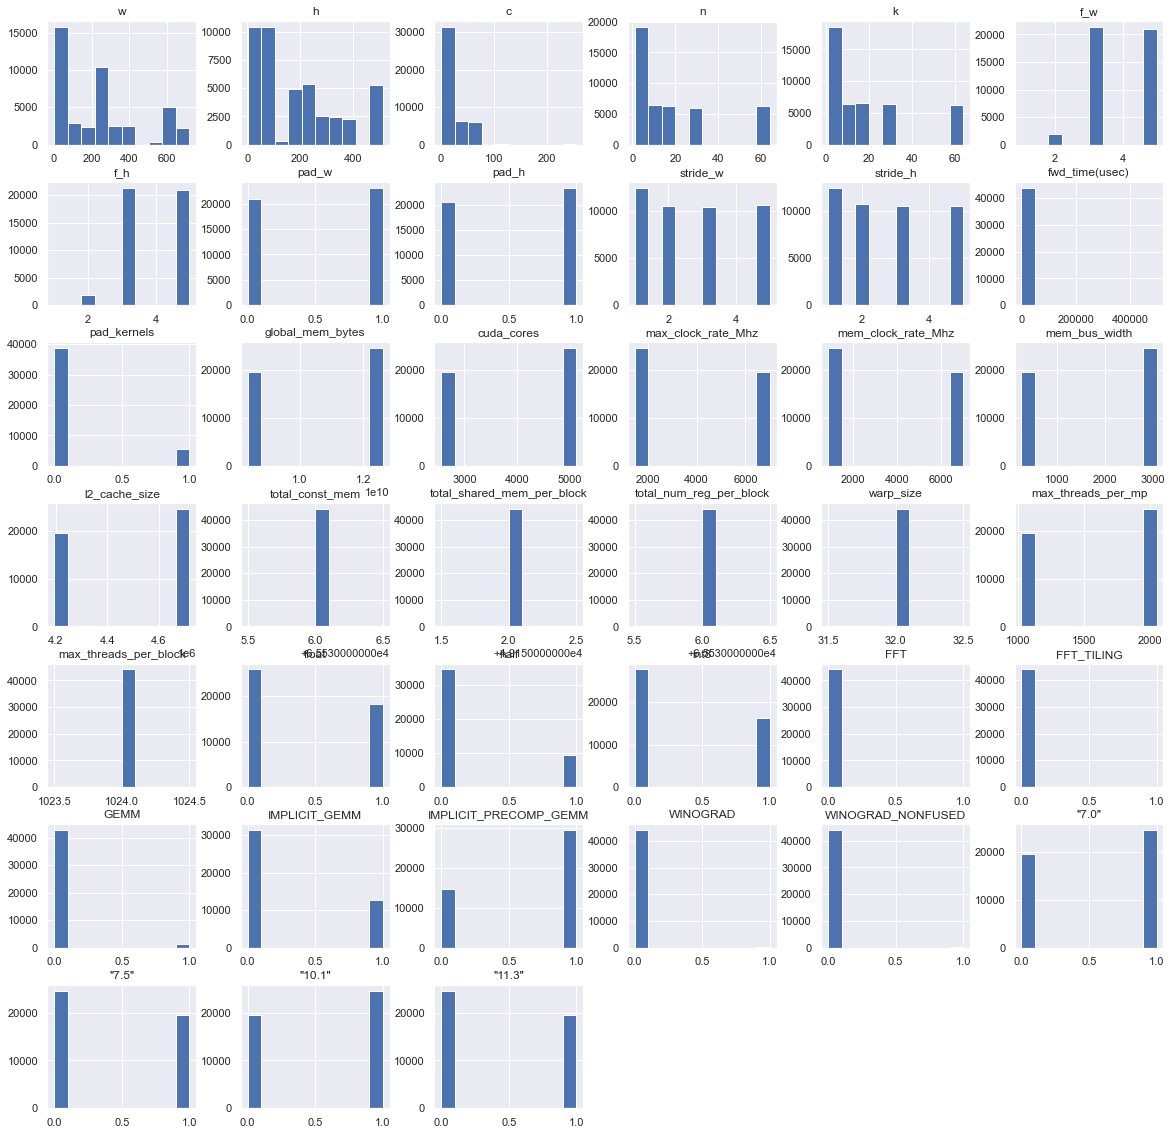

In [23]:
fig = plt.figure()
df.hist(figsize=(20,20))

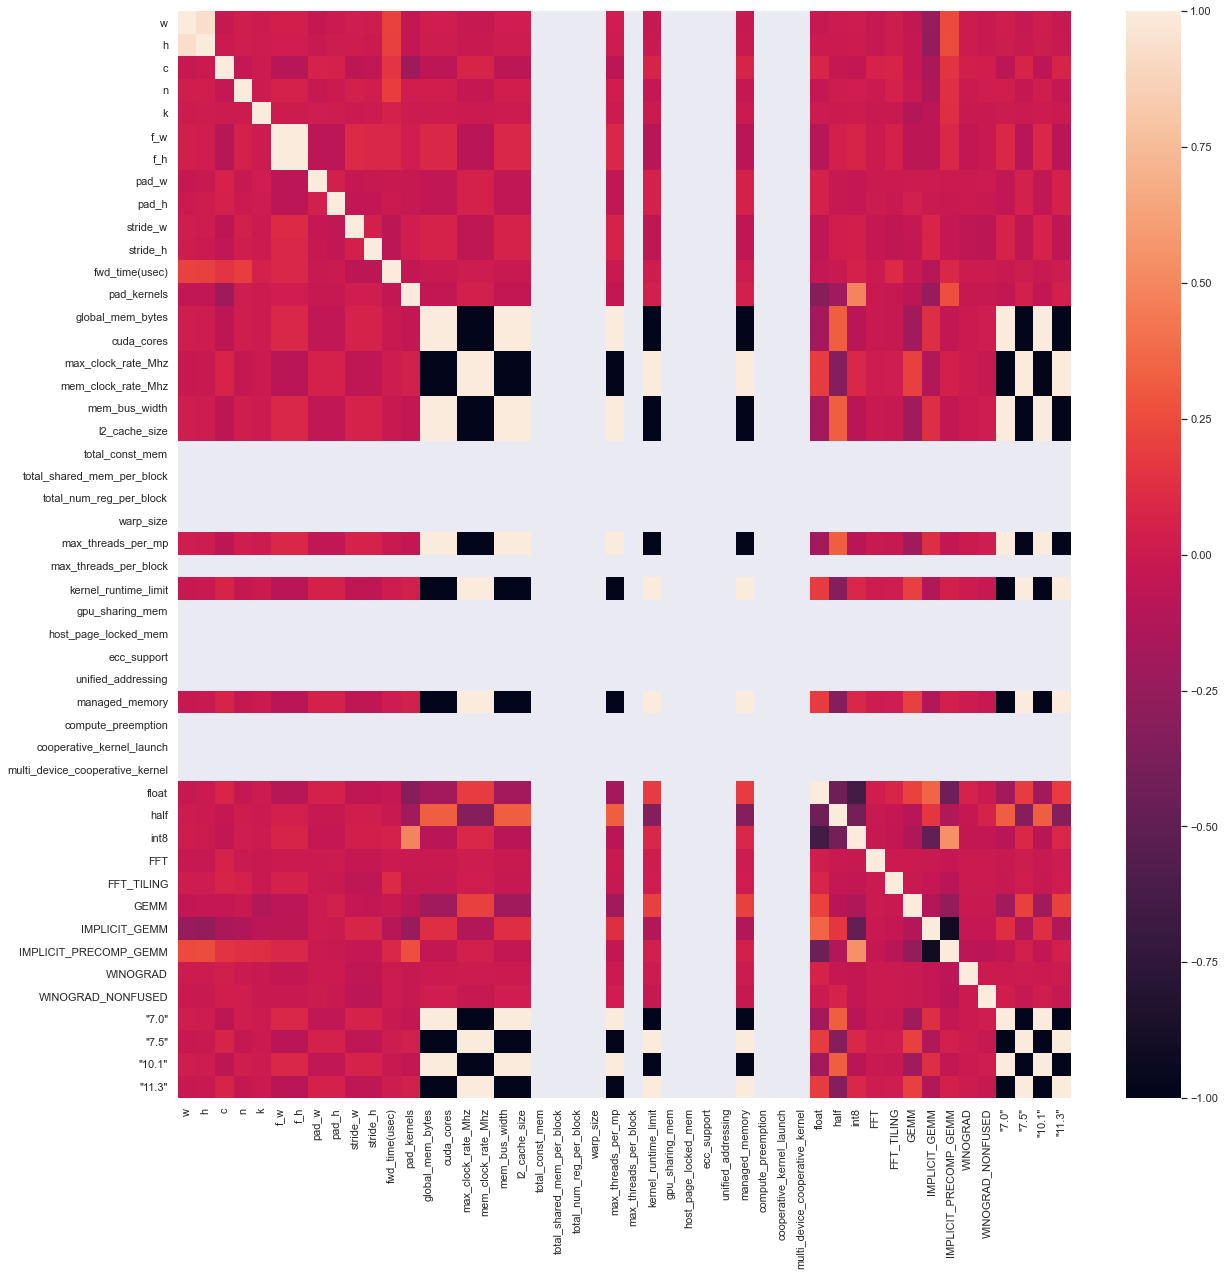

In [24]:
fig = plt.figure(figsize=(20,20))
ax = sns.heatmap(df.corr())

In [8]:
y = df['fwd_time(usec)']
X = df.drop(columns=['fwd_time(usec)'])

X, y = normalize(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8)

In [9]:
clf = MLPRegressor(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
clf.score(X_test, y_test)

0.7303265098887253

In [10]:
clf = LinearRegression()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.16784788996311661

In [11]:
clf = Ridge()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.1678499146818876

In [12]:
clf = Lasso(alpha=0.1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.09618591362548312

In [13]:
clf = SVR()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.47432762985944277

In [14]:
clf = KNeighborsRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.4569964102884462

In [25]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5117276122856693

In [26]:
clf = RandomForestRegressor()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)


0.7925984327341282

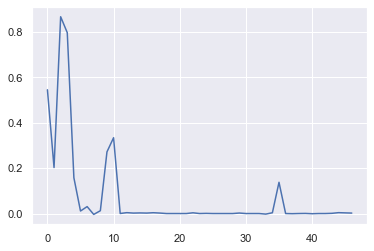

In [27]:
random_forest_result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(random_forest_result.importances_mean)

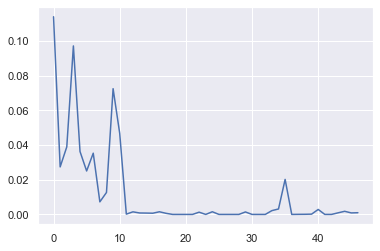

In [28]:
plt.plot(random_forest_result.importances_std)

In [29]:
importances = pd.Series(random_forest_result.importances_mean)
idx = importances[importances > 0.02].index
print('Most "important" columns in dataset: ')
df.columns[idx]

Most "important" columns in dataset: 


Index(['w', 'h', 'c', 'n', 'k', 'f_h', 'stride_w', 'stride_h', 'half'], dtype='object')

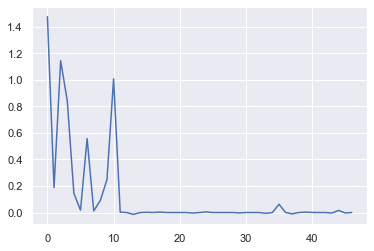

In [30]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)

decision_tree_results = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)
plt.plot(decision_tree_results.importances_mean)

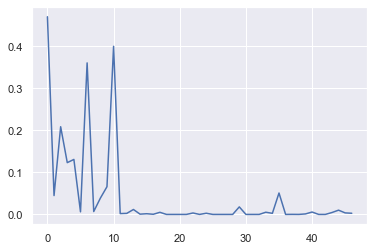

In [31]:
plt.plot(decision_tree_results.importances_std)


In [32]:
importances = pd.Series(decision_tree_results.importances_mean)
idx = importances[importances > 0.02].index
print('Most "important" columns in dataset: ')
df.columns[idx]

Most "important" columns in dataset: 


Index(['w', 'h', 'c', 'n', 'k', 'f_h', 'pad_h', 'stride_w', 'stride_h',
       'half'],
      dtype='object')